In [128]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

suffix = ''
suffix = '_v10b' # - > v6 of model predictions
suffix = '_v11' # ->v7 of model predictions
suffix = '_v11b' # ->v9 of model predictions

suffixB = suffix[:]

if suffix == '_v10b':
    modelversion = 'v6'
    mergedversion = ''
    inputversion = 'v10'
    lakecodelabel='level_0'
elif suffix =='_v11':
    modelversion = 'v7'
    mergedversion='_v11'
    inputversion = 'v11'
    lakecodelabel = 'lakecode'
elif suffix == '_v11b':
    modelversion = 'v9'
    mergedversion='_v11b'
    inputversion = 'v11b'
    lakecodelabel='lakecode'
    suffixB = '_v11'
volume = 'Data'
volume = 'My Passport for Mac'



chsize= 6
labelsize=8
annotation_txt_size = 7
abcd_size = 8
height_width_ratio = 2. / (1 + np.sqrt(5))

one_column_width = 3.5 # inches (this is from author guidelines)
two_column_width = 7.5 # inches (this is a guess)



In [129]:
#dficeon_all = pd.read_csv('/Volumes/Data/IceModels/model_predictions_iceon_v2.csv').rename({'index':'year'},axis=1)
#dficeoff_all = pd.read_csv('/Volumes/Data/IceModels/model_predictions_iceoff_v2.csv').rename({'index':'year'},axis=1)
dficeon_all = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/IceModels/model_predictions_iceon_{modelversion}.csv').rename({'index':'year'},axis=1)
dficeoff_all = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/IceModels/model_predictions_iceoff_{modelversion}.csv').rename({'index':'year'},axis=1)

ind = (dficeon_all==-999).any()
dficeon_all = dficeon_all.loc[:,~ind]
ind = (dficeoff_all==-999).any()
dficeoff_all = dficeoff_all.loc[:,~ind]


# remove Gull Lake from ice on projections to be consistent
dficeon_all = dficeon_all[dficeon_all.lakecode!='MINN6']

df_data0 = pd.read_csv(f'/Volumes/{volume}/IceModels/merged_model_input{mergedversion}.csv')


df_iceon_input = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffix}_input.csv')
df_iceoff_input = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffix}_input.csv')

df2 = pd.read_csv(f'/Volumes/{volume}/IceModels/model_input_{inputversion}.csv',low_memory=False)

lake_dict = df2.set_index(lakecodelabel)['lake'].to_dict()

Explore prevalence of models that have temperatures exceeding bounds of model

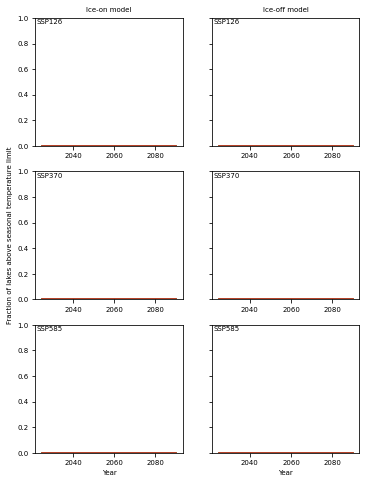

In [130]:
chsize = 7

fig,axes = plt.subplots(3,2,figsize=(5,8),sharey=True)
for ax,ssp in zip(axes.flatten()[::2],['126','370','585']):
    columns = [c for c in dficeon_all.columns if ssp in c]
    ((73-dficeon_all.loc[:,['year']+columns].groupby('year').count())/73.).rolling(20,center=True).mean().plot(legend=False,ax=ax)
    #ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
    ax.set_ylim(0,1)
    ax.tick_params(axis='both',labelsize=chsize)
    if ssp=='126':
        ax.set_title('Ice-on model',fontsize=chsize)
    if ssp=='370':
        ax.set_ylabel('Fraction of lakes above seasonal temperature limit',fontsize=chsize)
    ax.text(0.01,0.99,f"SSP{ssp}",ha='left',va='top',fontsize=chsize,transform=ax.transAxes)
    if ssp!='585':
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Year',fontsize=chsize)
for ax,ssp in zip(axes.flatten()[1::2],['126','370','585']):
    columns = [c for c in dficeoff_all.columns if ssp in c]
    ((74-dficeoff_all.loc[:,['year']+columns].groupby('year').count())/74.).rolling(20,center=True).mean().plot(legend=False,ax=ax)
    #ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
    ax.set_ylim(0,1)
    ax.tick_params(axis='both',labelsize=chsize)
    if ssp=='126':
        ax.set_title('Ice-off model',fontsize=chsize)
    #if ssp=='370':
    #    ax.set_ylabel('Fraction of lakes above local temperature limit',fontsize=chsize)
    ax.text(0.01,0.99,f"SSP{ssp}",ha='left',va='top',fontsize=chsize,transform=ax.transAxes)
    if ssp!='585':
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Year',fontsize=chsize)

fig.subplots_adjust(right=0.95, left=0.05)

Create a modified version of ice on and ice off where data are filled in with latest ice on and earliest ice off, to potentially aid with median measurements and visualizations below...

In [131]:
if suffix == '_v10b':

    dficeon_all_mod = dficeon_all.fillna(dficeon_all.groupby('lakecode').transform('max'))
    dficeoff_all_mod = dficeoff_all.fillna(dficeoff_all.groupby('lakecode').transform('min'))
else:
    dficeon_all_mod = dficeon_all.copy()
    dficeoff_all_mod = dficeoff_all.copy()

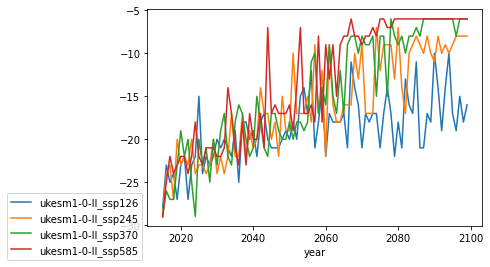

In [132]:
#df_data0 = pd.read_csv('/Volumes/Data/IceModels/merged_model_input.csv')
#ind = dficeon_all.lakecode=='JJM18'
ind = dficeon_all.lakecode.isin(dficeon_all.lakecode.unique())
dficeon_all_mod.loc[ind,['year']+[c for c in dficeon_all_mod.columns if 'ukesm' in c]].groupby('year').median().plot()
plt.legend(loc =5,bbox_to_anchor=(0,0))

Remove lake MINN6 (Gull) for ice on since it has a clear break in recording and step function in ice on dates

In [133]:
ind= ~df_data0[['ice_on_doy','Depth_avg','Lake_area']].isnull().any(axis=1)  & (df_data0.lakecode!='MINN6')

nyears = df_data0[ind].groupby(['lakecode']).ice_on_doy.count().min()
#df_data0[ind].drop_duplicates(['Lake_area','Depth_avg']).shape[0]

df_all = df_data0[ind].sort_values(['lakecode','start_year'],ascending=True)

df_iceon_limited = df_data0[ind].sort_values(['lakecode','start_year'],ascending=True).groupby(['lakecode']).tail(nyears)
print('Number of years in ice on data:',nyears)
print('Number of lakes:', df_iceon_limited.lakecode.drop_duplicates().shape[0])
print('Number of rows:', df_iceon_limited.shape[0])

ind= ~df_data0[['ice_off_doy','Depth_avg','Lake_area']].isnull().any(axis=1)
nyears = df_data0[ind].groupby(['lakecode']).ice_off_doy.count().min()
#df_data0[ind].drop_duplicates(['Lake_area','Depth_avg']).shape[0]

df_iceoff_limited = df_data0[ind].sort_values(['lakecode','start_year'],ascending=True).groupby(['lakecode']).tail(nyears)

print('\nNumber of years in ice off data:', nyears)
print('Number of lakes:', df_iceoff_limited.lakecode.drop_duplicates().shape[0])
print('Number of rows:', df_iceoff_limited.shape[0])


ind = df_data0.lakecode.isin(df_iceoff_limited.lakecode.tolist()+df_iceon_limited.lakecode.tolist())
df_all = df_data0[ind].sort_values(['lakecode','start_year'],ascending=True)



Number of years in ice on data: 31
Number of lakes: 73
Number of rows: 2263

Number of years in ice off data: 33
Number of lakes: 74
Number of rows: 2442


<AxesSubplot:xlabel='year'>

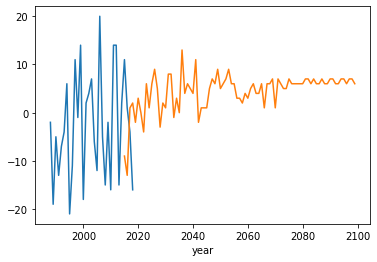

In [134]:
lc = 'DMR1'
df_iceon_limited[df_iceon_limited.lakecode==lc].set_index('start_year').ice_on_doy.plot()
dficeon_all[dficeon_all.lakecode==lc].set_index('year')[[c for c in dficeon_all.columns if ('gfdl' in c) & 
                                                         ('585' in c)]].median(axis=1).plot()

In [135]:
earliest_to_latest_spring = df_iceoff_limited.groupby('lakecode').TMINMAX_MAM.mean().sort_values(ascending = False).index

In [136]:
#df_iceon_limited

In [137]:
slope100_order = df_iceon_limited.groupby('lakecode').Slope_100.mean().sort_values(ascending=True).index


In [138]:
df_ = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_limited_seasonal_6and8params{suffix}_lake_errors.csv')
df_['sort_column'] = df_.ice_off_rmse + df_.ice_on_rmse
rmse_order = df_.sort_values('sort_column').lakecode.values
rmse_on_order = df_.sort_values('ice_on_rmse').lakecode.values
rmse_off_order = df_.sort_values('ice_off_rmse').lakecode.values


In [139]:
#dfpredictions_on

array([<AxesSubplot:title={'center':'Depth_avg'}>,
       <AxesSubplot:title={'center':'Elevation'}>,
       <AxesSubplot:title={'center':'Slope_100'}>,
       <AxesSubplot:title={'center':'Lake_area'}>,
       <AxesSubplot:title={'center':'Shore_dev'}>], dtype=object)

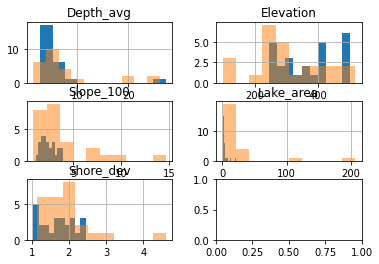

In [140]:
fig, axes = plt.subplots(3,2)
df_data0[df_data0.lakecode.isin(rmse_order[:25])].drop_duplicates('lakecode')[
    ['Depth_avg','Elevation','Slope_100','Lake_area','Shore_dev']].hist(ax=axes.flatten()[:5])
df_data0[df_data0.lakecode.isin(rmse_order[-25:])].drop_duplicates('lakecode')[
    ['Depth_avg','Elevation','Slope_100','Lake_area','Shore_dev']].hist(ax=axes.flatten()[:5],color='C1',alpha=0.5)


Earliest date for one lake is 1983. Latest date for another lake is 1995. Go with earliest 10-year period

In [141]:
#df_all

In [142]:
df_all.groupby('lakecode').start_year.min().max(), df_all.groupby('lakecode').start_year.max().min()

(1981.0, 1996.0)

<AxesSubplot:>

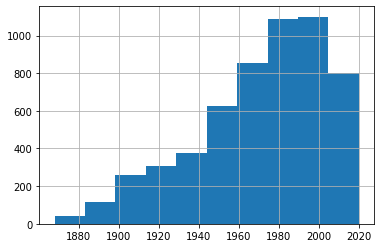

In [143]:
df_all[df_all.start_year.isin([1980])].lakecode.unique().shape
df_all.start_year.hist()

Read in all data, not just data used to fit model. Determine mean and adjust ice_on_doy to anomalies

In [144]:
dfts = df_all[['lakecode','start_year','ice_on_doy','ice_off_doy']]

iceon_mean = dfts[dfts.start_year.between(1980,1999)].dropna().groupby('lakecode').ice_on_doy.mean()
iceon_mean = iceon_mean.drop('MINN6')

iceoff_mean = dfts[dfts.start_year.between(1980,1999)].dropna().groupby('lakecode').ice_off_doy.mean()
dfts = dfts.merge(iceon_mean.rename('ice_on_normal'),left_on='lakecode',right_index=True,how='outer').merge(iceoff_mean.rename('ice_off_normal'),left_on='lakecode',right_index=True,how='outer')

In [145]:
dfts['ice_on_anomaly'] = dfts['ice_on_doy'] - dfts['ice_on_normal']
dfts['ice_off_anomaly'] = dfts['ice_off_doy'] - dfts['ice_off_normal']

In [146]:
dfts

,lakecode,start_year,ice_on_doy,ice_off_doy,ice_on_normal,ice_off_normal,ice_on_anomaly,ice_off_anomaly
0,DMR1,1868.0,-21.0,106.0,-5.2,84.00,-15.8,22.00
1,DMR1,1869.0,-29.0,102.0,-5.2,84.00,-23.8,18.00
2,DMR1,1870.0,-7.0,92.0,-5.2,84.00,-1.8,8.00
3,DMR1,1871.0,-12.0,114.0,-5.2,84.00,-6.8,30.00
4,DMR1,1872.0,-31.0,113.0,-5.2,84.00,-25.8,29.00
...,...,...,...,...,...,...,...,...
7444,xKB1987,2012.0,NaN,117.0,-36.8,92.25,NaN,24.75
7445,xKB1987,2013.0,NaN,NaN,-36.8,92.25,NaN,NaN
7446,xKB1987,2014.0,NaN,86.0,-36.8,92.25,NaN,-6.25
7447,xKB1987,2015.0,NaN,76.0,-36.8,92.25,NaN,-16.25


Read in historical model predictions
- see Notebook "5 - Model exploration" (directly from model fitting, used to measure AME and RSME)
- see Notebook "7 - Predictions" (using RF model's `pred` function for years 1960-2020)


In [147]:
dfpredictions_on = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffix}_predictions.csv')
dfpredictions_off = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffix}_predictions.csv')

dfpredictions_on = dfpredictions_on.merge(iceon_mean,left_on='lakecode',right_index=True, how='outer').rename({'ice_on_doy':'yactual_mean'},axis=1)

dfpredictions_off = dfpredictions_off.merge(iceoff_mean,left_on='lakecode',right_index=True, how='outer').rename({'ice_off_doy':'yactual_mean'},axis=1)

dfpredictions_on['actual_anomaly'] = dfpredictions_on['yactual'] - dfpredictions_on['yactual_mean']
dfpredictions_off['actual_anomaly'] = dfpredictions_off['yactual'] - dfpredictions_off['yactual_mean']
dfpredictions_on['pred_anomaly'] = dfpredictions_on['ypred'] - dfpredictions_on['yactual_mean']
dfpredictions_off['pred_anomaly'] = dfpredictions_off['ypred'] - dfpredictions_off['yactual_mean']


These predictions are using the RF pred functionality.
- PLUS historical weather station data

In [148]:
dfpredictions_onB = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffixB}_predictionsB.csv')
dfpredictions_offB = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffixB}_predictionsB.csv')

dfpredictions_onB = dfpredictions_onB.merge(dfts[['lakecode','start_year','ice_on_doy']],left_on=['year','lakecode'],right_on=['start_year','lakecode']).rename({'ice_on_doy':'yactual'},axis=1)
dfpredictions_offB = dfpredictions_offB.merge(dfts[['lakecode','start_year','ice_off_doy']],left_on=['year','lakecode'],right_on=['start_year','lakecode']).rename({'ice_off_doy':'yactual'},axis=1)


dfpredictions_onB = dfpredictions_onB.merge(iceon_mean,left_on='lakecode',right_index=True, how='outer').rename({'ice_on_doy':'yactual_mean'},axis=1)

dfpredictions_offB = dfpredictions_offB.merge(iceoff_mean,left_on='lakecode',right_index=True, how='outer').rename({'ice_off_doy':'yactual_mean'},axis=1)

dfpredictions_onB['actual_anomaly'] = dfpredictions_onB['yactual'] - dfpredictions_onB['yactual_mean']
dfpredictions_offB['actual_anomaly'] = dfpredictions_offB['yactual'] - dfpredictions_offB['yactual_mean']
dfpredictions_onB['pred_anomaly'] = dfpredictions_onB['ypred'] - dfpredictions_onB['yactual_mean']
dfpredictions_offB['pred_anomaly'] = dfpredictions_offB['ypred'] - dfpredictions_offB['yactual_mean']

#dfpredictions_on[dfpredictions_on.lakecode=='MINN6']
dfpredictions_offB['residual'] = dfpredictions_offB['yactual'] - dfpredictions_offB['ypred']

<AxesSubplot:>

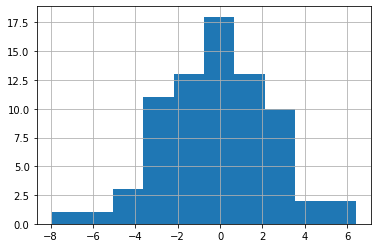

In [149]:
dfpredictions_off.groupby('lakecode').residual.mean().hist()

In [150]:
dfpredictions_onB

,year,ypred,lakecode,start_year,yactual,yactual_mean,actual_anomaly,pred_anomaly
0,1960,-3.0,DMR1,1960.0,-12.0,-5.2,-6.8,2.2
1,1961,-13.0,DMR1,1961.0,-15.0,-5.2,-9.8,-7.8
2,1962,-11.0,DMR1,1962.0,-19.0,-5.2,-13.8,-5.8
3,1963,1.0,DMR1,1963.0,-11.0,-5.2,-5.8,6.2
4,1964,-11.0,DMR1,1964.0,-16.0,-5.2,-10.8,-5.8
...,...,...,...,...,...,...,...,...
3839,2012,-32.0,xKB1987,2012.0,NaN,-36.8,NaN,4.8
3840,2013,-36.0,xKB1987,2013.0,NaN,-36.8,NaN,0.8
3841,2014,-38.0,xKB1987,2014.0,NaN,-36.8,NaN,-1.2
3842,2015,-10.0,xKB1987,2015.0,NaN,-36.8,NaN,26.8


In [151]:
#for lc in ['DMR1','DMR2','JJM18']:
#    ind2 = dfpredictions_on['lakecode']==lc
#    dfpredictions_on[ind2].set_index('year')[['pred_anomaly','actual_anomaly']].plot()
#    ind3 = dfproj_on['lakecode']==lc
#    dfproj_on.loc[ind3,['year','gfdl-esm4_ssp126']].set_index('year').plot()

Plot all lakes on same plot.
- historical
- projections

In [152]:
dfproj_on = dficeon_all.merge(iceon_mean, left_on='lakecode',right_index=True, how='outer').rename({'ice_on_doy':'historical_mean'},axis=1)
dfproj_off= dficeoff_all.merge(iceoff_mean, left_on='lakecode',right_index=True, how='outer').rename({'ice_off_doy':'historical_mean'},axis=1)



In [153]:
dfproj_on = dficeon_all_mod.merge(iceon_mean, left_on='lakecode',right_index=True, how='outer').rename({'ice_on_doy':'historical_mean'},axis=1)
dfproj_off= dficeoff_all_mod.merge(iceoff_mean, left_on='lakecode',right_index=True, how='outer').rename({'ice_off_doy':'historical_mean'},axis=1)

dfproj_on.iloc[:,2:-1] = dfproj_on.iloc[:,2:-1]- dfproj_on[['historical_mean']].values
dfproj_off.iloc[:,2:-1] = dfproj_off.iloc[:,2:-1]- dfproj_off[['historical_mean']].values

dfproj_on.groupby('year').median()

,gfdl-esm4_ssp126,gfdl-esm4_ssp245,gfdl-esm4_ssp370,gfdl-esm4_ssp585,mpi-esm1-2-hr_ssp126,mpi-esm1-2-hr_ssp245,mpi-esm1-2-hr_ssp370,mpi-esm1-2-hr_ssp585,mri-esm2-0_ssp126,mri-esm2-0_ssp245,mri-esm2-0_ssp370,mri-esm2-0_ssp585,ukesm1-0-ll_ssp126,ukesm1-0-ll_ssp245,ukesm1-0-ll_ssp370,ukesm1-0-ll_ssp585,historical_mean
year,,,,,,,,,,,,,,,,,
2015.0,1.650000,-0.526316,1.400000,-0.368421,1.650000,1.333333,0.800000,1.333333,9.800000,8.050000,8.800000,6.000000,3.473684,2.421053,3.000000,2.700000,-30.263158
2016.0,0.450000,8.470588,1.062500,0.800000,13.923077,3.052632,4.800000,2.800000,2.684211,0.000000,-0.076923,1.421053,7.500000,5.421053,6.062500,5.133333,-30.263158
2017.0,8.800000,0.750000,4.850000,4.800000,1.230769,6.450000,7.500000,6.600000,6.368421,1.263158,9.157895,6.923077,5.800000,7.400000,2.176471,9.150000,-30.263158
2018.0,3.150000,2.263158,9.052632,6.200000,3.333333,4.800000,3.600000,3.800000,-0.722222,-0.842105,5.650000,2.466667,6.600000,5.500000,6.133333,6.466667,-30.263158
2019.0,-0.250000,5.923077,2.050000,1.800000,4.100000,5.800000,0.187500,4.650000,7.150000,0.450000,7.650000,12.789474,3.700000,10.052632,7.300000,7.550000,-30.263158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095.0,12.150000,10.230769,8.500000,19.052632,10.000000,12.950000,9.157895,9.500000,0.333333,10.450000,12.100000,16.950000,11.500000,18.789474,23.050000,23.473684,-30.263158
2096.0,8.800000,5.800000,11.100000,18.000000,7.750000,9.250000,11.450000,10.000000,3.800000,11.062500,9.650000,11.230769,11.300000,19.050000,20.473684,23.473684,-30.263158
2097.0,8.923077,10.470588,12.000000,18.000000,2.100000,7.923077,9.923077,9.473684,8.600000,14.500000,13.176471,18.789474,13.800000,19.923077,23.466667,23.473684,-30.263158


In [154]:
#y = dfpred.groupby('year').actual_anomaly.mean()
#y.plot()
#y.rolling(20,center=True).mean().plot()
#plt.axhline(0)
dfproj_on.lakecode.unique().shape#.lakecode.unique().shape

(73,)

Get mean and range for all SSP126, all SSP370, all SSP585 for 2080-2099 range

In [155]:
dfproj_on

,lakecode,year,gfdl-esm4_ssp126,gfdl-esm4_ssp245,gfdl-esm4_ssp370,gfdl-esm4_ssp585,mpi-esm1-2-hr_ssp126,mpi-esm1-2-hr_ssp245,mpi-esm1-2-hr_ssp370,mpi-esm1-2-hr_ssp585,mri-esm2-0_ssp126,mri-esm2-0_ssp245,mri-esm2-0_ssp370,mri-esm2-0_ssp585,ukesm1-0-ll_ssp126,ukesm1-0-ll_ssp245,ukesm1-0-ll_ssp370,ukesm1-0-ll_ssp585,historical_mean
0,DMR1,2015.0,4.2,-3.8,0.2,-3.8,7.2,7.2,-2.8,8.2,12.2,14.2,12.2,8.2,5.2,2.2,2.2,3.2,-5.2
1,DMR1,2016.0,-0.8,16.2,-0.8,-7.8,14.2,9.2,9.2,3.2,14.2,6.2,-0.8,-4.8,9.2,6.2,11.2,5.2,-5.2
2,DMR1,2017.0,13.2,-1.8,6.2,6.2,1.2,11.2,12.2,10.2,7.2,-1.8,16.2,12.2,10.2,9.2,3.2,10.2,-5.2
3,DMR1,2018.0,6.2,4.2,10.2,7.2,5.2,5.2,9.2,3.2,-3.8,-2.8,3.2,7.2,6.2,6.2,7.2,11.2,-5.2
4,DMR1,2019.0,-3.8,13.2,-0.8,3.2,4.2,3.2,1.2,5.2,3.2,-4.8,15.2,15.2,9.2,13.2,9.2,7.2,-5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6285,xKB1987,2095.0,19.8,11.8,8.8,31.8,11.8,12.8,11.8,11.8,1.8,12.8,15.8,33.8,10.8,29.8,31.8,31.8,-36.8
6286,xKB1987,2096.0,6.8,1.8,12.8,28.8,7.8,11.8,10.8,12.8,3.8,12.8,12.8,10.8,12.8,31.8,30.8,31.8,-36.8
6287,xKB1987,2097.0,12.8,13.8,14.8,31.8,3.8,8.8,12.8,12.8,7.8,29.8,30.8,29.8,16.8,31.8,31.8,31.8,-36.8
6288,xKB1987,2098.0,5.8,31.8,11.8,30.8,2.8,11.8,11.8,14.8,6.8,6.8,22.8,31.8,11.8,31.8,31.8,31.8,-36.8


In [156]:
dfproj_on.set_index(['year','lakecode'])[columns].stack().reset_index().pivot_table(index='year',columns=(
    'lakecode','level_2'),values=0)

lakecode             DMR1                                         \
level_2  gfdl-esm4_ssp585 mpi-esm1-2-hr_ssp585 mri-esm2-0_ssp585   
year                                                               
2015.0               -3.8                  8.2               8.2   
2016.0               -7.8                  3.2              -4.8   
2017.0                6.2                 10.2              12.2   
2018.0                7.2                  3.2               7.2   
2019.0                3.2                  5.2              15.2   
...                   ...                  ...               ...   
2095.0               12.2                 12.2              12.2   
2096.0               11.2                 11.2              11.2   
2097.0               12.2                 12.2              12.2   
2098.0               12.2                 11.2              12.2   
2099.0               11.2                 11.2              12.2   

lakecode                                DMR2                       \
level_2  ukesm1-0-ll_ssp585 gfdl-esm4_ssp585 mpi-esm1-2-hr_ssp585   
year                                                                
2015.0                  3.2             -9.1                  2.9   
2016.0                  5.2             -9.1                 -5.1   
2017.0                 10.2             -7.1                  2.9   
2018.0                 11.2              2.9                  3.9   
2019.0                  7.2             -4.1                  1.9   
...                     ...              ...                  ...   
2095.0                 12.2              8.9                  3.9   
2096.0                 12.2              7.9                  4.9   
2097.0                 12.2              8.9                  2.9   
2098.0                 12.2              8.9                  7.9   
2099.0                 12.2              6.9                  6.9   

lakecode                                                  HB01  \
level_2  mri-esm2-0_ssp585 ukesm1-0-ll_ssp585 gfdl-esm4_ssp585   
year                                                             
2015.0                -0.1               -4.1             -9.2   
2016.0                -8.1                1.9              4.8   
2017.0                 5.9                1.9              8.8   
2018.0                -6.1               -4.1              1.8   
2019.0                 6.9                2.9              0.8   
...                    ...                ...              ...   
2095.0                 8.9                8.9             20.8   
2096.0                 6.9                8.9             21.8   
2097.0                 8.9                8.9             21.8   
2098.0                 8.9                8.9             20.8   
2099.0                 8.9                8.9              9.8   

lakecode                       ...           xKB1774                     \
level_2  mpi-esm1-2-hr_ssp585  ... mri-esm2-0_ssp585 ukesm1-0-ll_ssp585   
year                           ...                                        
2015.0                   -6.2  ...         12.789474           8.789474   
2016.0                   -0.2  ...          4.789474           6.789474   
2017.0                    3.8  ...         12.789474          12.789474   
2018.0                    3.8  ...          9.789474           9.789474   
2019.0                    4.8  ...         18.789474           8.789474   
...                       ...  ...               ...                ...   
2095.0                   18.8  ...         43.789474          43.789474   
2096.0                    6.8  ...         38.789474          43.789474   
2097.0                    6.8  ...         43.789474          43.789474   
2098.0                   18.8  ...         43.789474          43.789474   
2099.0                   14.8  ...         43.789474          43.789474   

lakecode          xKB1921                                         \
level_2  gfdl-esm4_ssp585 mpi-esm1-2

In [157]:
dfproj_on.set_index(['year','lakecode'])[columns].stack().reset_index().pivot_table(index='year',columns=(
    'lakecode','level_2'),values=0).rolling(20,center=True).mean().dropna(
    how='all',axis=0).loc[2090,:].describe()




count    292.000000
mean      16.527232
std        9.278235
min        1.800000
25%        9.747368
50%       14.625000
75%       21.617561
max       62.316667
Name: 2090.0, dtype: float64

In [158]:
years = 2090
dfssp = pd.DataFrame()
for ssp in ['126','370','585']:
    columns = [c for c in dfproj_on.columns if ssp in c]
    col_dict = {i:i.split('_ssp')[0] for i in columns}
    values_on = dfproj_on.set_index(['year','lakecode'])[columns].rename(col_dict,axis=1).stack().reset_index().pivot_table(index='year',columns=('lakecode','level_2'),values=0).rolling(20,center=True).mean().loc[years,:]
    values_off = dfproj_off.set_index(['year','lakecode'])[columns].rename(col_dict,axis=1).stack().reset_index().pivot_table(index='year',columns=('lakecode','level_2'),values=0).rolling(20,center=True).mean().loc[years,:]
    dfssp[f"{ssp}_on"] = values_on
    dfssp[f"{ssp}_off"] = values_off

In [159]:
dfssp[dfssp.index.isin(['DMR1'],level=0)]

126_on  126_off  370_on  370_off  585_on  585_off
lakecode level_2                                                         
DMR1     gfdl-esm4        9.85    -4.35   10.80   -20.60   11.70   -26.40
         mpi-esm1-2-hr    7.85    -0.35   11.10   -20.90   11.10   -21.75
         mri-esm2-0       8.15    -3.70   11.35   -23.05   11.55   -25.70
         ukesm1-0-ll     11.65   -25.40   12.20   -29.90   12.20   -30.00

In [160]:
print(dfssp[['126_on','370_on','585_on']].stack().mean(),dfssp[['126_off','370_off','585_off']].stack().mean())




13.19058781481276 -21.416963640687083


In [161]:
lake_area_median = df_data0[df_data0.lakecode.isin(dfproj_off.lakecode.unique())].drop_duplicates('lakecode').Lake_area.median()
lake_depth_median = df_data0[df_data0.lakecode.isin(dfproj_off.lakecode.unique())].drop_duplicates('lakecode').Depth_avg.median()
lake_depth_median, lake_area_median
lakegroups = [df_data0[df_data0.Depth_avg < lake_depth_median].lakecode.drop_duplicates().tolist(),
              df_data0[df_data0.Depth_avg >= lake_depth_median].lakecode.drop_duplicates().tolist()]

lakegroups = [df_data0[df_data0.Lake_area < lake_area_median].lakecode.drop_duplicates().tolist(),
              df_data0[df_data0.Lake_area >= lake_area_median].lakecode.drop_duplicates().tolist()]

ind_large_deep = (df_data0.Depth_avg >= lake_depth_median) & (df_data0.Lake_area >= lake_area_median)
ind_small_shallow = (df_data0.Depth_avg < lake_depth_median) & (df_data0.Lake_area < lake_area_median)

lakegroups = [df_data0[ind_large_deep].lakecode.drop_duplicates().tolist(),
                    df_data0[ind_small_shallow].lakecode.drop_duplicates().tolist()]

In [162]:
np.log10(df_data0.Lake_area.min())

-0.9208187539523752

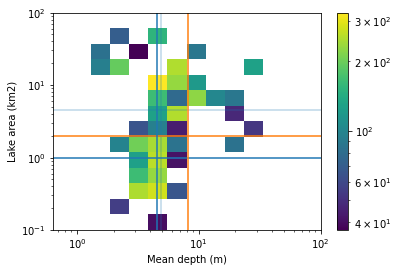

(12, 404) (12, 404)


In [163]:
import matplotlib as mpl
ind = ~df_data0.Depth_avg.isnull() & ~df_data0.Lake_area.isnull()

nbins = 15
plt.hist2d(df_data0.Depth_avg[ind],
           df_data0.Lake_area[ind],
           bins = [np.logspace(-0.2,2,nbins),np.logspace(-1,2,nbins)],
           norm = mpl.colors.LogNorm())
plt.ylabel('Lake area (km2)')
plt.xlabel('Mean depth (m)')
plt.yscale('log')
plt.xscale('log')
plt.axhline(df_data0.Lake_area.median(),alpha=0.3)
plt.axvline(df_data0.Depth_avg.median(),alpha=0.3)


depth_cutoff = 4.5
dmult = 1.8
area_cutoff = 1
plt.axhline(area_cutoff)
plt.axhline(area_cutoff*2,color='C1')


plt.axvline(depth_cutoff)
plt.axvline(depth_cutoff*dmult,color='C1')



plt.colorbar()
plt.show()



ind1 = (df_data0.Depth_avg< depth_cutoff) & (df_data0.Lake_area < area_cutoff)
ind2 = (df_data0.Depth_avg>= depth_cutoff*dmult) & (df_data0.Lake_area >= area_cutoff*2)


print(df_data0[ind1].drop_duplicates('lakecode').shape,df_data0[ind2].drop_duplicates('lakecode').shape)


#df_data0.Depth_avg.hist()

# large deep then small shallow
lakegroups = [df_data0.loc[ind2,'lakecode'].drop_duplicates().tolist(),
            df_data0.loc[ind1,'lakecode'].drop_duplicates().tolist()]



In [164]:

df_data0[df_data0.lat==df_data0.lat.max()].lakecode.unique()[0]

'MINN38'

In [165]:
print(lake_dict['xKB1640'])
display(df_data0[df_data0.lakecode=='xKB1640'].drop_duplicates('lakecode').T.dropna().tail(17))

print(lake_dict['MINN38'])
display(df_data0[df_data0.lakecode=='MINN38'].drop_duplicates('lakecode').T.dropna().tail(17))

siseebakwet


,7014
Lake_area,4.78
Shore_len,8.66
Shore_dev,1.12
Vol_total,30.65
Depth_avg,6.4
Dis_avg,0.321
Res_time,1105.2
Elevation,404.0
Slope_100,2.55
TMINMAX_MAM,3.05


shagawa


,4614
Lake_area,8.71
Shore_len,25.62
Shore_dev,2.45
Vol_total,84.17
Depth_avg,9.7
Dis_avg,2.597
Res_time,375.1
Elevation,404.0
Slope_100,3.35
TMINMAX_MAM,3.031522


126_on 1481.0 0.016078604701676907
kstest 0.3125 0.01790296070526876
370_on 1596.0 0.00115480177007619
kstest 0.375 0.0021345842830588885
585_on 1511.0 0.008614138031887934
kstest 0.2916666666666667 0.033173073759550795
12
['126_on', '370_on', '585_on']
12
['126_on', '370_on', '585_on']


,126_on,370_on,585_on
count,292.000000,292.000000,292.000000
mean,8.538362,14.506170,16.527232
std,6.555134,8.683082,9.278235
min,-1.800000,1.150000,1.800000
25%,3.737500,8.080769,9.747368
50%,7.561538,12.747222,14.625000
75%,12.008333,19.800000,21.617561
max,33.916667,56.516667,62.316667


126_off 843.0 0.023785662624995155
kstest 0.375 0.0021345842830588885
370_off 852.5 0.028454055247842638
kstest 0.25 0.0995639662871848
585_off 988.0 0.23089075255406288
kstest 0.20833333333333334 0.2502930720844449
12
['126_off', '370_off', '585_off']
12
['126_off', '370_off', '585_off']


,126_off,370_off,585_off
count,292.000000,292.000000,292.000000
mean,-9.611028,-25.113254,-29.526610
std,10.264835,11.891151,12.147473
min,-41.900000,-57.268421,-59.218421
25%,-13.900000,-33.562500,-37.461029
50%,-6.007018,-21.250000,-29.421053
75%,-2.850000,-15.612500,-20.713816
max,5.100000,-6.344118,-4.744118


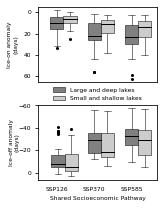

In [166]:
from scipy.stats import mannwhitneyu, kstest

chsize = 6

fig,axes = plt.subplots(2,1,sharex=True,figsize=(88./25.4*0.7,88./25.4*0.9))

for c,ax in zip(['on','off'],axes.flatten()):
    if c=='on':
        color = '0.8'
        lw=0.5
        offset = 0
        manage_ticks=True
        labelpad=5.6
    else:
        color = '0.5'
        lw=0.5
        offset = 0.03
        manage_ticks=False
        labelpad=-1
        
    columns = [i for i in dfssp.columns if c in i]

    labels = [f"SSP{i.split('_')[0]}" for i in columns]
    if c=='off':
        labels = ["","",""]
    xx = dfssp.loc[dfssp.index.isin(lakegroups[0],level=0),columns]
    yy = dfssp.loc[dfssp.index.isin(lakegroups[1],level=0),columns]
    for cc in columns:
        res = mannwhitneyu(xx[cc],yy[cc])
        print(cc, res.statistic, res.pvalue)
        res = kstest(xx[cc],yy[cc])
        print('kstest',res.statistic, res.pvalue)
    bp = []
    width_offset = 0.7 / len(lakegroups)
    for i,lg in enumerate(lakegroups):
        print(len(lg))
        offset_i = 0 - 0.7/2. + i*width_offset
        if i!=0:
            color = '0.8'
            manage_ticks=False
        else:
            color = '0.5'
        ind = dfssp.index.isin(lg,level=0)
        print(columns)
        bp_ = ax.boxplot(dfssp.loc[ind,columns],flierprops={'markersize':2,'markerfacecolor':'k'},patch_artist=True,
               boxprops={'facecolor':color,'lw':lw}, widths=0.7/2.,
               #showmeans = True,
               #meanprops={'marker':'*','markerfacecolor':'yellow','markeredgecolor':'black'},
               positions = [1+offset+offset_i, 2+offset_i, 3+offset_i],
               whiskerprops={'markeredgecolor':color,'lw':lw},
               capprops = {'markeredgecolor':color,'lw':lw},
               medianprops={'color':'k'},manage_ticks=manage_ticks,
               labels=labels)
        bp.append(bp_)
    
    display(dfssp[columns].describe())
    ax.tick_params(axis='both',labelsize=chsize)
    ax.tick_params(axis='x',bottom=False)
    ax.set_ylim(ax.get_ylim()[1],ax.get_ylim()[0])
    ax.set_ylabel(f'Ice-{c} anomaly\n(days)',fontsize=chsize,labelpad=labelpad)
    if c=='on':
        ax.legend([bp[0]['boxes'][0], bp[1]['boxes'][0]],
              ['Large and deep lakes', 'Small and shallow lakes'],loc='upper center',
                  ncol=1,fontsize=chsize,bbox_to_anchor=[0.5,0.],frameon=False)
#ax.text(0.54,0.83,'*',transform = ax.transAxes,fontsize=12,weight='heavy', ha='center',va='bottom')
#ax.text(0.85,0.83,'*',transform = ax.transAxes,fontsize=12, weight='heavy',ha='center',va='bottom')


#fig.suptitle(f'Projected {years-10}-{years+9} mean anomaly',fontsize=chsize)
ax.set_xlabel('Shared Socioeconomic Pathway',fontsize=chsize)
#ax.text(0.5,0.7,'I    C    E        O    N',rotation = 20,ha='center',weight='bold',va='center',style='oblique',color='0.8',fontsize=chsize, transform=ax.transAxes)
#ax.text(0.5,0.7,'I    C    E        O    N',rotation = 20,ha='center',weight='ultralight',va='center',style='oblique',color='0.9',fontsize=chsize, transform=ax.transAxes)
#ax.text(0.1,0.1,'ICE OFF',ha='left',va='bottom',fontsize=chsize,transform=ax.transAxes)
fig.subplots_adjust(left=0.24,right=0.92,bottom=0.13,top=0.9,hspace=0.3)
#fig.savefig(f'/Users/blagrave/Projects/IcePhenologyModels/Figures/ice_proj{years}_boxplot.png',dpi=300)
#fig.savefig(f'/Users/blagrave/Projects/IcePhenologyModels/Figures/ice_proj{years}_boxplot.pdf')

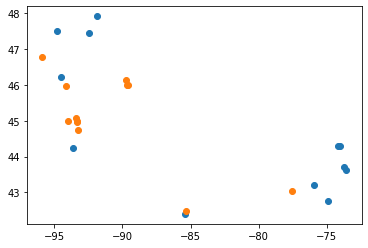

In [167]:
for c in lakegroups:
    ind = df_data0.lakecode.isin(c)
    lat,lon = df_data0.loc[ind,['lat','lon']].drop_duplicates().T.values
    plt.plot(lon,lat,marker='o',ls='none')

### Average across all lakes and all SSP

### Minimum and maximum duration change 

In [168]:
foo = dfproj_on.groupby(['lakecode']).rolling(20,center=True).mean().dropna()
print(foo[foo.year==2089.5].iloc[:,1:-1].stack().mean())
foo2 = dfproj_off.groupby(['lakecode']).rolling(20,center=True).mean().dropna()
print(foo2[foo2.year==2089.5].iloc[:,1:-1].stack().mean())


foo3 = foo[foo.year==2089.5].iloc[:,1:-1].mean(axis=1).reset_index().set_index('lakecode').merge(foo2[foo2.year==2089.5].iloc[:,1:-1].mean(axis=1).reset_index().set_index('lakecode'),left_index=True,right_index=True)
print((foo3['0_x']- foo3['0_y']).mean(),(foo3['0_x']- foo3['0_y']).min(),(foo3['0_x']- foo3['0_y']).max())


13.052788157278515
-20.612905573470588
33.8556821632624 19.00625 53.33958333333333


1.3834567740457482 0.0504575257117963
1.5555555555555556 3.4538011695906423
1.0001225462037497 0.0036898928405511193
1.0 2.6526315789473642
-7.576933606578976


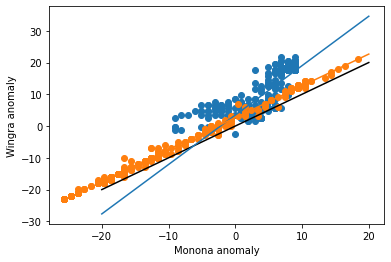

In [169]:
from scipy import stats

#dfpredictions_on[dfpredictions_on.lakecode=='xKB1987'].set_index('year')
x = dfproj_on.loc[dfproj_on.lakecode.isin(['DMR2']),[c for c in dfproj_on.columns if '585' in c]].stack()
y = dfproj_on.loc[dfproj_on.lakecode.isin(['JJM18']),[c for c in dfproj_on.columns if '585' in c]].stack()
x2 = dfproj_off.loc[dfproj_off.lakecode.isin(['DMR2']),[c for c in dfproj_off.columns if '585' in c]].stack()
y2 = dfproj_off.loc[dfproj_off.lakecode.isin(['JJM18']),[c for c in dfproj_off.columns if '585' in c]].stack()
plt.plot(x,y,ls='none',marker='o')
plt.xlabel('Monona anomaly')
plt.ylabel('Wingra anomaly')

plt.plot(x2,y2,ls='none',marker='o')
plt.xlabel('Monona anomaly')
plt.ylabel('Wingra anomaly')

plt.plot([-20,20],[-20,20],color='k')

x_ = np.linspace(-20,20,2)
a,b,_,_ = stats.mstats.theilslopes(y,x)
lr = stats.linregress(x,y)
print(lr.slope, lr.stderr)

plt.plot(x_, a*x_ + b,color='C0')
print(a,b)
a,b,_,_ = stats.mstats.theilslopes(y2,x2)
lr2 = stats.linregress(x2,y2)
print(lr2.slope, lr2.stderr)


plt.plot(x_, a*x_ + b,color='C1')

print(a,b)

# is difference = 0?

Z = (lr2.slope - lr.slope)/np.sqrt(lr.stderr**2 + lr2.stderr**2)
print(Z)

In [170]:
dfpredictions_on

,lakecode,year,residual,ypred,yactual,yactual_mean,actual_anomaly,pred_anomaly
0,DMR1,1988.0,0.0,-2.0,-2.0,-5.2,3.2,3.2
1,DMR1,1989.0,17.0,-2.0,-19.0,-5.2,-13.8,3.2
2,DMR1,1990.0,-1.0,-6.0,-5.0,-5.2,0.2,-0.8
3,DMR1,1991.0,5.0,-8.0,-13.0,-5.2,-7.8,-2.8
4,DMR1,1992.0,4.0,-3.0,-7.0,-5.2,-1.8,2.2
...,...,...,...,...,...,...,...,...
2258,xKB1987,2004.0,1.0,-16.0,-17.0,-36.8,19.8,20.8
2259,xKB1987,2005.0,1.0,-27.0,-28.0,-36.8,8.8,9.8
2260,xKB1987,2006.0,-3.0,-34.0,-31.0,-36.8,5.8,2.8
2261,xKB1987,2007.0,3.0,-32.0,-35.0,-36.8,1.8,4.8


126
2050 +8.7 (-2.2 - +33.3)
2070 +8.8 (-2.7 - +33.1)
2090 +8.5 (-1.8 - +33.9)
-35.91024087462246
370
2050 +9.5 (-1.6 - +32.8)
2070 +12.5 (+0.9 - +42.9)
2090 +14.5 (+1.1 - +56.5)
35.91024087462246
585
2050 +10.7 (-1.1 - +35.4)
2070 +13.0 (-0.6 - +49.7)
2090 +16.5 (+1.8 - +62.3)
-35.91024087462246
126
2050 -9.0 (-39.8 - +5.6)
2070 -10.2 (-40.1 - +6.0)
2090 -9.4 (-41.9 - +7.2)
-54.848776353887224
370
2050 -11.4 (-40.3 - +5.1)
2070 -19.3 (-51.2 - +2.1)
2090 -24.9 (-57.3 - -0.3)
54.848776353887224
585
2050 -14.2 (-43.9 - +5.4)
2070 -20.7 (-55.1 - +3.5)
2090 -29.3 (-59.2 - +1.6)
-54.848776353887224


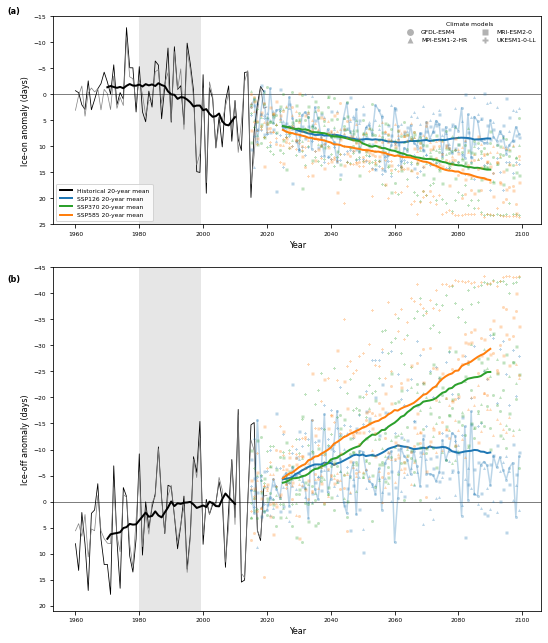

In [177]:
from matplotlib.ticker import MultipleLocator
width = two_column_width*25.4
figsize = (width/25.4, width/25.4*1.2)

isimip_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR','MRI-ESM2-0']#,'UKESM1-0-LL']
isimip_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR','MRI-ESM2-0','UKESM1-0-LL']
isimip_models = ['GFDL-ESM4','MPI-ESM1-2-HR','MRI-ESM2-0','UKESM1-0-LL']


yrange1 = [25,-15]
yrange2 = [21,-45]
#fig, axes = plt.subplots(2,1, figsize=figsize, gridspec_kw={'height_ratios': [41.4,61.5]})

fig, axes = plt.subplots(2,1, figsize=figsize, gridspec_kw={'height_ratios': [yrange1[0]-yrange1[1],yrange2[0]-yrange2[1]]})




topmargin =0.14
bottommargin = 0.6
leftmargin=0.64
rightmargin=0.1
hmargin = 0.6

top = 1. - topmargin/figsize[1]
bottom = bottommargin/figsize[1]
left = leftmargin/figsize[0]
right = 1. - rightmargin/figsize[1]

pltheight = (figsize[1] - topmargin - bottommargin - hmargin) / 2.
hspace = hmargin / pltheight


#chsize = 8
for ylabel,ax, dfpred,dfproj in zip(['Ice-on anomaly (days)','Ice-off anomaly (days)'],axes.flatten(),[dfpredictions_onB,dfpredictions_offB],[dfproj_on,dfproj_off]):
    y = dfpred.groupby('year').actual_anomaly.mean() # mean of all lakes
    ysmoothed = y.rolling(20, center=True).mean()
    #display(ysmoothed.loc[[1989,1990]])
    x = y.index
    # mean of all lakes
    ax.plot(x,y.values,color='k',lw=0.8)
    # smoothed mean of all lakes
    ax.plot(x,ysmoothed.values,color='k',lw=2,zorder=3,label='Historical 20-year mean')
    
    # predicted historical mean of all lakes
    y = dfpred.groupby('year').pred_anomaly.mean() # mean of all lakes
    ysmoothed = y.rolling(20, center=True).mean()
    
    x = y.index
    # predicted historical mean of all lakes
    ax.plot(x,y.values, color='0.5',lw=0.7)
    #ax.plot(x,ysmoothed.values,color='0.7',lw=2)

    ax.axhline(0,lw=0.5,color='k')
    # has 15 model projections for each year
    # mean of all lakes, as done above for historical data
    y = dfproj.groupby('year').mean()
    y = dfproj.set_index(['lakecode','year'])
    
    #dfproj_on.set_index(['year','lakecode'])[columns].stack(
    #).reset_index().pivot_table(index='year',columns=(
    #'lakecode','level_2'),values=0).rolling(20,center=True).mean().dropna(
    #how='all',axis=0).loc[2090,:].describe()
    
    #y = dfproj.groupby('year').median()
    #x = y.index
    for ssp,cc in zip(['126','370','585'],['C0','C2','C1']):
        
        # all predictions for all lakes for given SSP (5 models in 5 columns)
        y_ = y[[c for c in y.columns if (ssp in c) & np.any([i.lower() in c for i in isimip_models])]]
        # get mean deviation for each year, keeping 5 columns
        y_ = y_.reset_index().groupby('year').mean()
        # x is the year
        x = y_.index
        
        plt_symbols = []
        for c,m in zip(y_.columns,['o','^','s','P','*'][:len(isimip_models)]):
            #print(c,m)
            l1, = ax.plot(x,y_[c].values,markerfacecolor='k',alpha=0.3,
                          markersize=3,markeredgecolor='none',ls='none',marker=m)
            l1.remove()
            if ('gfdl' in c) & ('126' in c):
                ls0 = '-'
            else:
                ls0 = 'none'
            ax.plot(x,y_[c].values,markerfacecolor=cc,alpha=0.3,color=cc,
                    markersize=3,markeredgecolor='none',ls=ls0,marker=m)
            plt_symbols.append(l1)
        #display(y_.describe())
        
        y_ = y[[c for c in y.columns if (ssp in c) & np.any([i.lower() in c for i in isimip_models])]]
        #display(y_)
        #display(y_.stack().reset_index())
        # get mean of all data in given year (all lakes and all 5 models)
        y_ = y_.stack().reset_index().pivot_table(index='year',columns=(
            'lakecode','level_2'),values=0).rolling(20,center=True).mean()#.loc[2090,:].mean()
        #display(y_.dropna(how='all',axis=0))
        #y_mean = y_.stack().reset_index().groupby('year')[0].mean().rolling(20,center=True).mean()
        #y_median = y_.stack().reset_index().groupby('year')[0].median().rolling(20,center=True).mean()
        #y_25 = y_.stack().reset_index().groupby('year')[0].quantile(0.25).rolling(20,center=True).mean()
        #y_75 = y_.stack().reset_index().groupby('year')[0].quantile(0.75).rolling(20,center=True).mean()
        #y_05 = y_.stack().reset_index().groupby('year')[0].quantile(0.05).rolling(20,center=True).mean()
        #y_95 = y_.stack().reset_index().groupby('year')[0].quantile(0.95).rolling(20,center=True).mean()
        print(f"{'='*16}\n{ssp}\n{'='*16}")
        for jj in [2050,2070,2090]:
            print(jj, f"{y_.loc[jj,:].mean():+0.1f} ({y_.loc[jj,:].quantile(0.0):+0.1f} - {y_.loc[jj,:].quantile(1.0):+0.1f})")
        y_mean = y_.mean(axis=1)
        x = y_mean.index
        #ax.fill_between(x,y_25,y_75,facecolor=cc,alpha=0.2)
        ax.plot(x,y_mean,color=cc,alpha=1.0,lw=2, label=f'SSP{ssp} 20-year mean')
        
        ax.set_ylim(ax.get_ylim()[1],ax.get_ylim()[0])
        
        print(ax.get_ylim()[1]-ax.get_ylim()[0])
        
        #ax.set_ylim(30,-50)
        #y_.plot(ls='-',marker='.',alpha=0.5)
        #print(ssp)
        #mins = y_.rolling(20, center=True).mean().min(axis=1).loc[[2050,2070,2090]].round(1)
        #medians = y_.rolling(20, center=True).mean().median(axis=1).loc[[2050,2070,2090]].round(1)
        #maxs = y_.rolling(20, center=True).mean().max(axis=1).loc[[2050,2070,2090]].round(1)
        #for jj in [2050,2070,2090]:
        #    print(jj, f"{medians[jj]:+0.1f} ({mins[jj]:+0.1f} – {maxs[jj]:+0.1f})")
        #ax.plot(x,y_.rolling(20, center=True).mean().median(axis=1).values, color=cc,alpha=1.0,lw=2, label=f'SSP{ssp} 20-year mean')
        
    ax.axvspan(1980,1999,color='0.9',zorder=1)
    ax.set_xlabel('Year',fontsize=labelsize)
    ax.set_ylabel(ylabel,fontsize=labelsize)
    ax.tick_params(axis='both',labelsize=chsize)
    
    if ax== axes.flatten()[0]:
        #plt_symbols2 = plt_symbols.copy()
        #for p in plt_symbols2:
        #    p.set_markerfacecolor('k')
        #    p.set_alpha(1.0)
        #    p.remove()
        #print(len(plt_symbols), len(isimip_models))
        legend1 = ax.legend(plt_symbols, isimip_models,title='Climate models', 
                            frameon=False, loc='upper right',ncol=2,fontsize=chsize,markerscale=2.3)
        plt.setp(legend1.get_title(),fontsize=chsize)
        #legend1.legendHandles[2].set_markerfacecolor('k')
        ax.legend(fontsize=chsize,borderpad=0.6, loc='lower left', frameon=True)
        ax.add_artist(legend1)
    else:
        ax.yaxis.set_major_locator(MultipleLocator(5))

        
        
axes.flatten()[0].text(0,0.999,'(a)',weight='heavy',fontsize=abcd_size,transform=fig.transFigure,ha='left',va='top')
axes.flatten()[0].text(0,(1-0.414),'(b)',weight='heavy',fontsize=abcd_size,transform=fig.transFigure,ha='left',va='top')

axes.flatten()[0].set_ylim(yrange1)
#axes.flatten()[0].axhline(24)
#axes.flatten()[0].axhline(23)



axes.flatten()[1].set_ylim(yrange2)
#axes.flatten()[1].axhline(-43)



fig.subplots_adjust(left=left,right=right, top=top, bottom = bottom,hspace=hspace)
fig.savefig(f'/Users/blagrave/Projects/IcePhenologyModels/Figures/model_projections_{suffix}.pdf')
fig.savefig(f'/Users/blagrave/Projects/IcePhenologyModels/Figures/model_projections_{suffix}.png',dpi=300)



In [178]:
dfproj_on

,lakecode,year,gfdl-esm4_ssp126,gfdl-esm4_ssp245,gfdl-esm4_ssp370,gfdl-esm4_ssp585,mpi-esm1-2-hr_ssp126,mpi-esm1-2-hr_ssp245,mpi-esm1-2-hr_ssp370,mpi-esm1-2-hr_ssp585,mri-esm2-0_ssp126,mri-esm2-0_ssp245,mri-esm2-0_ssp370,mri-esm2-0_ssp585,ukesm1-0-ll_ssp126,ukesm1-0-ll_ssp245,ukesm1-0-ll_ssp370,ukesm1-0-ll_ssp585,historical_mean
0,DMR1,2015.0,4.2,-3.8,0.2,-3.8,7.2,7.2,-2.8,8.2,12.2,14.2,12.2,8.2,5.2,2.2,2.2,3.2,-5.2
1,DMR1,2016.0,-0.8,16.2,-0.8,-7.8,14.2,9.2,9.2,3.2,14.2,6.2,-0.8,-4.8,9.2,6.2,11.2,5.2,-5.2
2,DMR1,2017.0,13.2,-1.8,6.2,6.2,1.2,11.2,12.2,10.2,7.2,-1.8,16.2,12.2,10.2,9.2,3.2,10.2,-5.2
3,DMR1,2018.0,6.2,4.2,10.2,7.2,5.2,5.2,9.2,3.2,-3.8,-2.8,3.2,7.2,6.2,6.2,7.2,11.2,-5.2
4,DMR1,2019.0,-3.8,13.2,-0.8,3.2,4.2,3.2,1.2,5.2,3.2,-4.8,15.2,15.2,9.2,13.2,9.2,7.2,-5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6285,xKB1987,2095.0,19.8,11.8,8.8,31.8,11.8,12.8,11.8,11.8,1.8,12.8,15.8,33.8,10.8,29.8,31.8,31.8,-36.8
6286,xKB1987,2096.0,6.8,1.8,12.8,28.8,7.8,11.8,10.8,12.8,3.8,12.8,12.8,10.8,12.8,31.8,30.8,31.8,-36.8
6287,xKB1987,2097.0,12.8,13.8,14.8,31.8,3.8,8.8,12.8,12.8,7.8,29.8,30.8,29.8,16.8,31.8,31.8,31.8,-36.8
6288,xKB1987,2098.0,5.8,31.8,11.8,30.8,2.8,11.8,11.8,14.8,6.8,6.8,22.8,31.8,11.8,31.8,31.8,31.8,-36.8


In [172]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:
series = pd.Series(np.linspace(1,10,10), index = pd.date_range('2014-01-01', '2014-01-10', freq = 'D'))
series.rolling(6, min_periods=6, center=True).mean().head(10)

Calculate 20-year rolling mean for each lake

In [ ]:
mean20 = pd.DataFrame()
for name,group in dfproj_on.groupby('lakecode'):
    foo_ = group.set_index('year').rolling(20,center=True).mean().loc[[2050,2070,2090],:]
    foo_['lakecode'] = name
    mean20 = mean20.append(foo_.reset_index(),ignore_index=True)
mean20.set_index(['lakecode','year'])

---

Need to remove lakes that aren't well represented by grid cell. Look at historical data vs weather station data

In [ ]:
#df_diff

In [ ]:
# guess at lakes that are poorly modelled by climate model grid cells\
#KMS15, xKB1426, KMS5, KMS14, LR1, LR2

diff_cutoff = 3
df_diff = pd.read_csv('/Volumes/Data/IceModels/isimip_weather_differences_by_lakecode.csv',index_col=0)
skip_lakes  = df_diff[(np.abs(df_diff)>diff_cutoff).any(axis=1) & df_diff.index.isin(df_data0[~df_data0.Depth_avg.isnull()].lakecode)].index

In [ ]:
df_diff.hist()

In [ ]:
list_of_lakes = dfpredictions_off.lakecode.unique()

#skip_lakes = ['KMS24','KMS15','xKB1426','KMS17','KMS5','KMS14','LR1','LR2']
list_of_lakes = [l for l in list_of_lakes if l not in skip_lakes]
len(list_of_lakes)

In [ ]:
dficeon_anom = dficeon_all.copy()
dficeoff_anom = dficeoff_all.copy()

yon_mean = dficeon_all.merge(dfpredictions_on[['lakecode','yactual_mean']].drop_duplicates(),
                  left_on='lakecode',right_on='lakecode',validate='many_to_one',how='left')['yactual_mean']
yoff_mean = dficeoff_all.merge(dfpredictions_off[['lakecode','yactual_mean']].drop_duplicates(),
                  left_on='lakecode',right_on='lakecode',validate='many_to_one',how='left')['yactual_mean']
dficeon_anom.iloc[:,1:-1] = dficeon_all.iloc[:,1:-1].sub(yon_mean,axis=0)
dficeoff_anom.iloc[:,1:-1] = dficeoff_all.iloc[:,1:-1].sub(yoff_mean,axis=0)

#loc[ind,['year','lakecode']+[c for c in dficeon_all if '126' in c]] - 

In [ ]:
from scipy.signal import savgol_filter
#plt.plot(median_pred_on.index,median_pred_on['ssp126'])
#plt.plot(median_pred_on.index,savgol_filter(median_pred_on['ssp126'],11,3))
#median_pred_on['ssp126'].rolling(30).mean()

In [ ]:
#ax =dficeon_anom.set_index('year').plot(marker='.',ls='none')
fig,ax =plt.subplots()
dficeon_anom.loc[dficeon_anom.lakecode=='DMR1',['year']+[c for c in dficeon_anom.columns if 'ukesm' in c]].set_index('year').plot(marker='.',ls='-',ax=ax)
plt.legend(loc=7,bbox_to_anchor=(0.5,1),ncol=5)


In [ ]:
dficeon_anom.groupby('year').median()[[c for c in dficeon_anom if '126' in c]].median(axis=1).plot()
dficeon_anom.groupby('year').median()[[c for c in dficeon_anom if '370' in c]].median(axis=1).plot()
dficeon_anom.groupby('year').median()[[c for c in dficeon_anom if '585' in c]].median(axis=1).plot()

In [ ]:
model = 'gfdl'

median_pred_on = pd.DataFrame()
ind = dficeon_anom.lakecode.isin(list_of_lakes)
median_pred_on['ssp126'] = dficeon_anom.loc[ind,['year','lakecode']+[c for c in dficeon_anom if ('126' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()
median_pred_on['ssp370'] = dficeon_anom.loc[ind,['year','lakecode']+[c for c in dficeon_anom if ('370' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()
median_pred_on['ssp585'] = dficeon_anom.loc[ind,['year','lakecode']+[c for c in dficeon_anom if ('585' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()

median_pred_off = pd.DataFrame()
ind = dficeoff_anom.lakecode.isin(list_of_lakes)
median_pred_off['ssp126'] = dficeoff_anom.loc[ind,['year','lakecode']+[c for c in dficeoff_anom if ('126' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()
median_pred_off['ssp370'] = dficeoff_anom.loc[ind,['year','lakecode']+[c for c in dficeoff_anom if ('370' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()
median_pred_off['ssp585'] = dficeoff_anom.loc[ind,['year','lakecode']+[c for c in dficeoff_anom if ('585' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()

model = 'ssp' # i.e., median of all models
median2_pred_on = pd.DataFrame()
ind = dficeon_anom.lakecode.isin(list_of_lakes)
median2_pred_on['ssp126'] = dficeon_anom.loc[ind,['year','lakecode']+[c for c in dficeon_anom if ('126' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()
median2_pred_on['ssp370'] = dficeon_anom.loc[ind,['year','lakecode']+[c for c in dficeon_anom if ('370' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()
median2_pred_on['ssp585'] = dficeon_anom.loc[ind,['year','lakecode']+[c for c in dficeon_anom if ('585' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()

median2_pred_off = pd.DataFrame()
ind = dficeoff_anom.lakecode.isin(list_of_lakes)
median2_pred_off['ssp126'] = dficeoff_anom.loc[ind,['year','lakecode']+[c for c in dficeoff_anom if ('126' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()
median2_pred_off['ssp370'] = dficeoff_anom.loc[ind,['year','lakecode']+[c for c in dficeoff_anom if ('370' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()
median2_pred_off['ssp585'] = dficeoff_anom.loc[ind,['year','lakecode']+[c for c in dficeoff_anom if ('585' in c) & (model in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()



In [ ]:
ssp_color = {'126':'C0','370':'C2','585':'C1'}
model_marker = {'gfdl':'.','ipsl':'s','mpi':'^','mri':'x','ukesm':'+'}

for model in ['gfdl','ipsl','mpi','mri','ukesm']:
    for ssp in ['126','370','585']:
        columns = [c for c in dficeon_anom if (ssp in c) & (model in c)]
        plt.plot(dficeon_anom.groupby('year')[columns].mean(),ls='none',markeredgecolor='none',markersize=5,alpha=0.5,color=ssp_color[ssp],marker=model_marker[model])
        print(columns)
#        dficeon_anom[]

In [ ]:
def plot_predictions(historical, future, ax = None, mean = False, fontsize = 8, model='all',smooth=True, ylabel=None, win_size=31, ylim=None, list_of_lakes=None):
    if ax is None:
        fig,ax = plt.subplots()
    historical.set_index('year').actual_anomaly.plot(ls='none',marker='.',color='k',markersize=2,ax=ax,alpha=0.2)
    historical.groupby('year').pred_anomaly.mean().plot(ls='-',color='0.5',lw=2,ax=ax,alpha=0.7)
    historical.groupby('year').actual_anomaly.mean().plot(ls='-',color='k',lw=1,ax=ax,alpha=0.7)
    ssp_color = {'126':'C0','370':'C2','585':'C1'}
    model_marker = {'gfdl':'.','ipsl':'s','mpi':'^','mri':'x','ukesm':'+'}

    
    if model == 'all':
        models = ['gfdl','ipsl','mpi','mri','ukesm']
        mm = 'ssp'
    else:
        models = [model]
        mm = model
    if list_of_lakes is None:
        list_of_lakes = future.lakecode.unique()
    ind = future.lakecode.isin(list_of_lakes)

    future_median = pd.DataFrame()
    future_mean = pd.DataFrame()

    for ssp in ['126','370','585']:
#        future_median[f'ssp{ssp}'] = future.loc[ind,['year','lakecode']+[c for c in future.columns if (ssp in c) & (mm in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').median()
#        future_mean[f'ssp{ssp}'] = future.loc[ind,['year','lakecode']+[c for c in future.columns if (ssp in c) & (mm in c)]].set_index(['year','lakecode']).stack().reset_index().groupby('year').mean()

        future_median[f'ssp{ssp}'] = future[ind].set_index(['lakecode','year'])[[c for c in dficeon_anom.columns if (ssp in c) & (mm in c)]].median(axis=1).reset_index().groupby('year').median()
        
        #future_median[f'ssp{ssp}'] = future.loc[ind,['year','lakecode']+[c for c in future.columns if (ssp in c) & (mm in c)]].set_index(['year','lakecode']).median(axis=1).reset_index().groupby('year').median()
        future_mean[f'ssp{ssp}'] = future.loc[ind,['year','lakecode']+[c for c in future.columns if (ssp in c) & (mm in c)]].set_index(['year','lakecode']).median(axis=1).reset_index().groupby('year').mean()

        for m in models:

            columns = [c for c in future if (ssp in c) & (m in c)]
            #print(columns)
            ax.plot(future.groupby('year')[columns].mean(),ls='none',markeredgecolor='none',markersize=2,alpha=0.5,color=ssp_color[ssp],marker=model_marker[m])

    
    year = future_median.index

    for ssp,color in zip(['ssp126','ssp370','ssp585'],['C0','C2','C1']):
        y = future_median[ssp]
        if mean:
            y = future_mean[ssp]
        if smooth:
            ax.plot(year, y.rolling(win_size,center=True).mean(),color=color,lw=3)
            #ax.plot(year, savgol_filter(y,win_size,1),color=color,lw=2)
        else:
            ax.plot(year, y,color=color,lw=3)

    ax.axhline(0,color='k')
    ax.axvspan(1980,1999,alpha=0.1,color='k',zorder=1)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    if ylim is not None:
        ax.set_ylim(ylim)
    return future_median
 

In [ ]:
cutoff = 9

start_year, end_year = 1980,2100

mean=False

uppercutoff = 1e6

fontsize = 7

small = df_data0.loc[(df_data0.Lake_area.between(0,cutoff,inclusive='left')),'lakecode'].unique()
#medium = df_data0.loc[(df_data0.Lake_area.between(6,40)),'lakecode'].unique()
large = df_data0.loc[(df_data0.Lake_area.between(cutoff,uppercutoff,inclusive='both')),'lakecode'].unique()

fig, axes = plt.subplots(2,3,figsize=(130./25.4,130./25.4*0.95),sharex='all',sharey='row')
i= 0
for col in ['iceon','iceoff']:
    if col == 'iceoff':
        df1 = dfpredictions_off
        df1anom = dficeoff_anom
        ylabel = 'Ice off anomaly (days)'
        ylim = (-50,25)
    else:
        df1 = dfpredictions_on
        df1anom = dficeon_anom
        ylabel = 'Ice on anomaly (days)'
        ylim = (-20,25)
    for lc in [small, large, list(small)+list(large)]:
        #print([l for l in lc if l in list_of_lakes])
        #display(df_diff.loc[[l for l in lc if l in list_of_lakes],:].mean())
        ind = df1.lakecode.isin(lc) & df1.lakecode.isin(list_of_lakes) & df1.year.between(start_year,end_year)
        #print(df1[ind].lakecode.unique().shape)
        ind2 = df1anom.lakecode.isin(lc) & df1anom.lakecode.isin(list_of_lakes) & df1anom.year.between(start_year,end_year)
        ax = axes.flatten()[i]
        future_median = plot_predictions(df1[ind], df1anom[ind2], 
                         fontsize=fontsize,mean=mean,ax=ax, win_size=20, smooth=True, ylim=ylim,model='all',ylabel=ylabel)
        print(col,lc)
        display(future_median.reset_index().groupby(pd.cut(future_median.reset_index()['year'], np.arange(2020,2101,20), right=False)).mean())
        i = i+1
ax.text(0,1, '(a)',ha='left',va='top',weight='bold',fontsize=fontsize, transform = fig.transFigure)
ax.text(0,0.5, '(b)',ha='left',va='top',weight='bold',fontsize=fontsize, transform = fig.transFigure)

axes[0][0].text(0.5, 1.02, 'Smaller lakes ($<9$ km$^2$)',ha='center',va='bottom', transform=axes[0][0].transAxes,fontsize=fontsize)
axes[0][1].text(0.5, 1.02, 'Larger lakes ($\geq9$ km$^2$)',ha='center',va='bottom',transform=axes[0][1].transAxes,fontsize=fontsize)

for ax in axes.flatten():
    ax.tick_params(labelsize=fontsize)
    ax.set_xlabel('Year',fontsize=fontsize)

fig.subplots_adjust(right=0.95,top=0.95, left=0.1, bottom=0.09, hspace=0.1,wspace=0.1)
fig.savefig('/Users/blagrave/Projects/IcePhenologyModels/Figures/model_predictions.pdf')
fig.savefig('/Users/blagrave/Projects/IcePhenologyModels/Figures/model_predictions.png',dpi=300)

    

In [ ]:
dficeon_anom.set_index(['lakecode','year'])[[c for c in dficeon_anom.columns if '126' in c]].median(axis=1).reset_index().groupby('year').median()

In [ ]:
df1[df1.lakecode=='DMR1'].set_index('year').actual_anomaly.plot()
df1anom[df1anom.lakecode=='DMR1'].set_index('year').loc[:,[c for c in df1anom if 'ssp126' in c]].median(axis=1).plot()

In [ ]:
future_median.reset_index().groupby(pd.cut(future_median.reset_index()['year'], np.arange(2020,2101,20), right=False)).mean()

Ice on anomaly table

In [ ]:
iceon_summary = dficeon_anom.groupby(['lakecode',pd.cut(dficeon_anom['year'], np.arange(2020,2101,20), right=False)]).mean().rename({'year':'mean_year'},axis=1).reset_index()
for name,select in zip(['Small','Large'],[small,large]):
    print(name)
    lakes = [l for l in select if l in list_of_lakes]
    print(len(lakes))
    for ssp in ['ssp126','ssp370','ssp585']:
        for yr in [2049.5,2069.5,2089.5]:
            print(yr,ssp,iceon_summary.loc[(iceon_summary.mean_year==yr) & (iceon_summary.lakecode.isin(lakes)),[c for c in iceon_summary if ssp in c]].median(axis=1).median())

In [ ]:
iceoff_summary = dficeoff_anom.groupby(['lakecode',pd.cut(dficeoff_anom['year'], np.arange(2020,2101,20), right=False)]).mean().rename({'year':'mean_year'},axis=1).reset_index()
for name,select in zip(['Small','Large'],[small,large]):
    print(name)
    lakes = [l for l in select if l in list_of_lakes]
    print(len(lakes))
    for ssp in ['ssp126','ssp370','ssp585']:
        for yr in [2049.5,2069.5,2089.5]:
            print(yr,ssp,iceoff_summary.loc[(iceoff_summary.mean_year==yr) & (iceoff_summary.lakecode.isin(lakes)),[c for c in iceoff_summary if ssp in c]].median(axis=1).median())

In [ ]:
iceoff_summary = dficeoff_anom.groupby(['lakecode',pd.cut(dficeoff_anom['year'], np.arange(2020,2101,20), right=False)]).mean().rename({'year':'mean_year'},axis=1).reset_index()
for ssp in ['ssp126','ssp370','ssp585']:
    for yr in [2049.5,2069.5,2089.5]:
        print(yr,ssp,iceoff_summary.loc[(iceoff_summary.mean_year==yr),[c for c in iceoff_summary if ssp in c]].median(axis=1).median())

In [ ]:
dfpredictions_on[(dfpredictions_on.year<1980) & (dfpredictions_on.actual_anomaly<-10) & (dfpredictions_on.lakecode.isin(['JJM22', 'KMS10', 'KMS14', 'KMS18', 'LR1', 'MINN31', 'MINN6', 'xKB0014']))]

In [ ]:
dfpredictions_on[(dfpredictions_on.lakecode.isin(['KMS18']))].set_index('year').actual_anomaly.plot()

In [ ]:
smooth = True
win_size = 31

#dfpredictions_on.set_index('year').pred_anomaly.plot(ls='none',marker='.',color='k',alpha=0.4)
fig, axes = plt.subplots(2,1,figsize = (183./25.4, 183/25.4*0.9),sharex='col')

ax = axes[0]
dfpredictions_on.set_index('year').actual_anomaly.plot(ls='none',marker='.',color='k',markersize=2,ax=ax,alpha=0.2)
dfpredictions_on.groupby('year').pred_anomaly.mean().plot(ls='-',color='0.5',lw=4,ax=ax,alpha=0.7)
dfpredictions_on.groupby('year').actual_anomaly.mean().plot(ls='-',color='k',lw=3,ax=ax,alpha=0.7)
ssp_color = {'126':'C0','370':'C2','585':'C1'}
model_marker = {'gfdl':'.','ipsl':'s','mpi':'^','mri':'x','ukesm':'+'}

for model in ['gfdl','ipsl','mpi','mri','ukesm']:
    for ssp in ['126','370','585']:
        columns = [c for c in dficeon_anom if (ssp in c) & (model in c)]
        ax.plot(dficeon_anom.groupby('year')[columns].mean(),ls='none',markeredgecolor='none',markersize=2,alpha=0.5,color=ssp_color[ssp],marker=model_marker[model])

year = median2_pred_on.index

for ssp,color in zip(['ssp126','ssp370','ssp585'],['C0','C2','C1']):
    y = median2_pred_on[ssp]
    if smooth:
        ax.plot(year, savgol_filter(y,win_size,3),color=color,lw=3)
    else:
        ax.plot(year, y,color=color,lw=3)

ax.axhline(0,color='k')
ax.axvspan(1980,1999,alpha=0.1,color='k',zorder=1)
ax.set_ylabel('Ice on anomaly (days)')
ax.set_ylim(-20,20)

ax = axes[1]
dfpredictions_off.set_index('year').actual_anomaly.plot(ls='none',marker='.',color='k',markersize=2,ax=ax,alpha=0.2)
dfpredictions_off.groupby('year').pred_anomaly.mean().plot(ls='-',color='0.5',lw=4,ax=ax,alpha=0.7)
dfpredictions_off.groupby('year').actual_anomaly.mean().plot(ls='-',color='k',lw=3,ax=ax,alpha=0.7)

for model in ['gfdl','ipsl','mpi','mri','ukesm']:
    for ssp in ['126','370','585']:
        columns = [c for c in dficeoff_anom if (ssp in c) & (model in c)]
        ax.plot(dficeoff_anom.groupby('year')[columns].mean(),ls='none',markeredgecolor='none',markersize=2,alpha=0.5,color=ssp_color[ssp],marker=model_marker[model])

year = median2_pred_off.index

for ssp,color in zip(['ssp126','ssp370','ssp585'],['C0','C2','C1']):
    y = median2_pred_off[ssp]
    if smooth:
        ax.plot(year, savgol_filter(y,win_size,3),color=color,lw=3)
    else:
        ax.plot(year, y,color=color,lw=3)
        #median2_pred_off['ssp370'].plot(color='C2',ax=ax,alpha=1.0,lw=3)
#median2_pred_off['ssp585'].plot(color='C1',ax=ax,alpha=1.0,lw=3)
ax.set_ylim(-45,25)
ax.set_ylabel('Ice off anomaly (days)')

ax.axhline(0,color='k')
ax.axvspan(1980,1999,alpha=0.1,color='k',zorder=1)

fig.savefig('/Users/blagrave/Projects/IcePhenologyModels/Figures/rf_predictions.pdf')
fig.savefig('/Users/blagrave/Projects/IcePhenologyModels/Figures/rf_predictions.png',dpi=300)



In [ ]:
# group into different slope groups for ice on anomaly. ice off is mostly temperature, so ok as is

# Lake_area < 6 ; 6 < Lake_area < 40 ; Lake_area > 40

In [ ]:
small = df_data0.loc[(df_data0.Lake_area.between(0,6)),'lakecode'].unique()
medium = df_data0.loc[(df_data0.Lake_area.between(6,40)),'lakecode'].unique()
large = df_data0.loc[(df_data0.Lake_area.between(40,1e6)),'lakecode'].unique()

In [ ]:
pd.plotting.scatter_matrix(df_data0[[c for c in df_data0.columns[-12:] 
                                     if c not in ['Res_time','Dis_avg','Vol_total']]])

In [ ]:
dficeon_all_2 = dficeon_all.merge(dfpredictions_on[['lakecode',
                                    'yactual_1988_1995']].drop_duplicates('lakecode'),
                  left_on='lakecode',right_on='lakecode',validate='many_to_one')
#dficeon_all_2.sub( dficeon_all_2['yactual_1988_1995'],axis=0)
dficeon_all_2.iloc[:,:-2].sub(dficeon_all_2['yactual_1988_1995'],axis=0)

In [ ]:
figwidth = 183./25.4
figheight = 247./25.4

nplots = 11
ordered_columns = slope100_order
ordered_columns = rmse_on_order

for ii in range(int(np.ceil(len(ordered_columns) / nplots))):
    fig,axes = plt.subplots(nplots,1,sharex='col',sharey='row', figsize=(figwidth,figheight))

    colors = ['C0','C2','C1']
    for ax,lc in zip(axes.flatten(),ordered_columns[ii*nplots:(ii+1)*nplots]):
        ypred_on = dfpredictions_on[dfpredictions_on.lakecode==lc].set_index('year')['ypred']
        ypred_off = dfpredictions_off[dfpredictions_off.lakecode==lc].set_index('year')['ypred']
        ax.plot(ypred_on,color='0.5',marker='.',ls='none')
        #ax.plot(ypred_off,markerfacecolor='none',marker='o',ls='none',markersize=4,markeredgecolor='0.5')
        on_rmse = df_.loc[df_.lakecode==lc,'ice_on_rmse'].values[0]
        #off_rmse = df_.loc[df_.lakecode==lc,'ice_off_rmse'].values[0]
        on_historic = df_iceon_limited.loc[df_iceon_limited.lakecode==lc,:].set_index('start_year')['ice_on_doy']
        #off_historic = df_iceoff_limited.loc[df_iceoff_limited.lakecode==lc,:].set_index('start_year')['ice_off_doy']
        ax.plot(on_historic, color='k',alpha=1.0,marker='.',ls='none')
        #ax.plot(off_historic, markerfacecolor='none',markeredgecolor='k',markersize=4,alpha=1.0,marker='o',ls='none')
        i =0
        for ssp in ['126','370','585']:
            dficeon_all.loc[dficeon_all.lakecode==lc,['year']+[c for c in dficeon_all.columns if ssp in c]].set_index('year').median(axis=1).plot(ax=ax,color=colors[i])
         #   dficeoff_all.loc[dficeon_all.lakecode==lc,['year']+[c for c in dficeon_all.columns if ssp in c]].set_index('year').median(axis=1).plot(ax=ax,color=colors[i])
            i = i+1
        ax.text(0.01,0.5,f'{lake_dict[lc]} ({lc})',fontsize=8, transform = ax.transAxes)
        ax.set_ylabel('Day of year',fontsize=8)
        ax.set_xlabel('Year',fontsize=8)
        ax.tick_params(axis='both', labelsize=8)
        ax.set_ylim(ax.get_ylim()[1],ax.get_ylim()[0])
        ax.text(1.01,0.9,f"Slope_100: {df_iceon_limited.loc[df_iceon_limited.lakecode==lc,'Slope_100'].unique()[0]}",fontsize=8, transform = ax.transAxes)
        ax.text(1.01,0.7,f"Depth_avg: {df_iceon_limited.loc[df_iceon_limited.lakecode==lc,'Depth_avg'].unique()[0]}",fontsize=8, transform = ax.transAxes)
        ax.text(1.01,0.5,f"Lake_area: {df_iceon_limited.loc[df_iceon_limited.lakecode==lc,'Lake_area'].unique()[0]}",fontsize=8, transform = ax.transAxes)
        ax.text(1.01,0.3,f"Shore_dev: {df_iceon_limited.loc[df_iceon_limited.lakecode==lc,'Shore_dev'].unique()[0]}",fontsize=8, transform = ax.transAxes)
        ax.text(1.01,0.1,f"Elevation: {df_iceon_limited.loc[df_iceon_limited.lakecode==lc,'Elevation'].unique()[0]}",fontsize=8, transform = ax.transAxes)
        ax.text(0.5,0.5,f"RMSE (ice on): {on_rmse:.1f}",fontsize=8, transform = ax.transAxes)
        #ax.text(0.5,0.3,f"RMSE (ice off): {off_rmse:.1f}",fontsize=8, transform = ax.transAxes)
        #break
    #break
    fig.subplots_adjust(top = 0.95, bottom = 0.05,left=0.1, right=0.83)
    fig.savefig(f'/Volumes/Data/IceModels/page{ii+1}.pdf')
    #break

In [ ]:
dficeon_all